# Baseline: popular models

<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #91D6EF; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1>Import lib</h1></div>

In [1]:
# If the library is not installed - unlock the field 
!{sys.executable} -m pip install rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 649.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 28.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: pybind11
    Found existing installation: pybind11 2.10.0
    Uninstalling pybind11-2.10.0:
      Successfully uninstalled pybind11-2.10.0
  Attempting uninstall: Markdown
    Found existing installation: Markdown 3.3.7
    Uninstalling Markdown-3.3.7:
      Successfully uninstalled Markdown-3.3.7
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import pandas as pd
import numpy as np

import warnings
import seaborn as sns 


from rectools import Columns
from rectools.dataset import Dataset
from tqdm.auto import tqdm
from scipy.stats import mode
from pprint import pprint

warnings.filterwarnings("ignore")

# Get KION dataset 

<a href="https://ods.ai/competitions/competition-recsys-21/data"> Dataset description [ru] </a>


In [3]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [4]:
!unzip kion_train.zip

Archive:  kion_train.zip
   creating: kion_train/
  inflating: kion_train/interactions.csv  
  inflating: __MACOSX/kion_train/._interactions.csv  
  inflating: kion_train/users.csv    
  inflating: __MACOSX/kion_train/._users.csv  
  inflating: kion_train/items.csv    
  inflating: __MACOSX/kion_train/._items.csv  


In [5]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #91D6EF; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1>Мы решили сами проанализировать дату и выдать top-k популярных итемов рекомендаций</h1></div>

In [6]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [7]:
# Удалим все записи, в которых % от просмотреного видео был меньше 10%
old_length = interactions.shape[0]
interactions_update = interactions[interactions.watched_pct > 10]
new_length = interactions_update.shape[0]

print(f'Кол-во записей исходное: {old_length}')
print(f'Кол-во записей исходное: {new_length}')

Кол-во записей исходное: 5476251
Кол-во записей исходное: 3615270


In [8]:
# Удалим всех юзеров, у которых было  не более 2 взаимодействий
# Так-же удалим все итемы, с которыми было не более 2 взаимодействий
old_length = interactions_update.shape[0]


mask_df_users = interactions_update.groupby("user_id").count()[["item_id"]]
list_users = mask_df_users[mask_df_users.item_id > 4].index

mask_df_items =interactions_update.groupby("item_id").count()[["user_id"]]
list_items = mask_df_items[mask_df_items.user_id > 4].index

mask = ((interactions_update.user_id.isin(list_users)) &
        (interactions_update.item_id.isin(list_items))
       )

new_df = interactions_update[mask]

new_length = new_df.shape[0]

print(f'Кол-во записей исходное: {old_length}')
print(f'Кол-во записей исходное: {new_length}')

Кол-во записей исходное: 3615270
Кол-во записей исходное: 2646592


In [9]:
new_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
3,864613,7638,2021-07-05,14483,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0


In [10]:
#Посмотрим минимальную и максимальную дату записей
new_df['last_watch_dt'] = pd.to_datetime(new_df['last_watch_dt'])
new_df.last_watch_dt.describe()

count                 2646592
unique                    163
top       2021-06-30 00:00:00
freq                    32052
first     2021-03-13 00:00:00
last      2021-08-22 00:00:00
Name: last_watch_dt, dtype: object

In [11]:
# Нам дан промежуток почти в пол года. Оставим только последние 101 дней
finish = new_df.last_watch_dt.max() #set the date to compare
delta = np.timedelta64(101, 'D')
new_start = finish - delta

print(f'Кол-во записей исходное: {new_df.shape[0]}')

new_df = new_df[new_df.last_watch_dt > new_start]

print(f'Кол-во записей исходное: {new_df.shape[0]}')

Кол-во записей исходное: 2646592
Кол-во записей исходное: 2129437


In [12]:
# Посмотрим список популярных итемов, которые будут для юзера
popular_items = new_df.value_counts("item_id").rename_axis('item_id').reset_index(name='counts')
popular_items.head()

,item_id,counts
0,15297,63258
1,10440,57342
2,9728,56777
3,13865,55999
4,3734,41131


In [13]:
# Предположим, что все юзеры холодные. (Предположим, что я не знаю все итемы, которые раньше смотрел юзер) 
# И буду выдавать ему тупо top_K рекомендаций. Отправим это в модель и получим score
list_top_items = popular_items.head(10).item_id.values
list_top_items

array([15297, 10440,  9728, 13865,  3734,  4151,  2657,   142,  8636,
        7571])

##  SCORE: model "StupidTop" - 0.0791033

## У наших юзеров уже есть просмотренные фильмы, и мы можем советовать ему фильмы, которые он уже все посмотрел. Нам нужно описать эту логику для использования в дальнейшем 

In [14]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [15]:
# Соберем все итемы по юзерам
user_watched = interactions.groupby('user_id')['item_id'].apply(list)
user_watched = user_watched.reset_index()

In [16]:
user_watched.head()

,user_id,item_id
0,0,"[7102, 14359, 15297, 6006, 9728, 12192]"
1,1,"[3669, 10440]"
2,2,"[7571, 3541, 15266, 13867, 12841, 10770, 4475,..."
3,3,"[12192, 9728, 16406, 15719, 10440, 3475, 2025,..."
4,4,"[4700, 6317]"


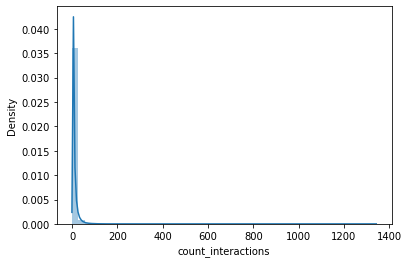

In [17]:
# Посмотрим максимальное кол-во взаимодействий юзера
user_watched['count_interactions'] = user_watched["item_id"].apply(lambda x: len(x))
sns_plot = sns.distplot(user_watched['count_interactions'])
fig = sns_plot.get_figure()

In [18]:
# График не совсем понятен. Посмотрим значения в верхних процентилях 
user_watched['count_interactions'].quantile([.8, .85, 0.9, 0.95, 0.99, 0.999], interpolation="nearest")

0.800      7
0.850     10
0.900     13
0.950     21
0.990     49
0.999    119
Name: count_interactions, dtype: int64

In [19]:
#  Убрав выбросы "очень горячих" пользователей. (Кстати, хороший вопрос - один ли это человек? Может это вообще тестеровщик? Или с аккаунта сразу много человек)
#  Создадим список рекомендаций на 131 значение.
list_top_items = popular_items.head(131).item_id.values
list_top_items

array([15297, 10440,  9728, 13865,  3734,  4151,  2657,   142,  8636,
        7571,  7102,  4495,  4457,  7829, 12995,  1844,  6809,  7417,
        4740,  9996,  3784,  3935, 16166,  7793, 14703, 14431, 12192,
       11237, 11778,  3182, 14317,  5434,  4436, 12173, 16228,  7626,
         512, 10464, 14741, 14901,  5693,  5411, 16270, 12324,  1449,
        1132,  6402, 15464,  7582, 13018,  6455,  1916,  6162, 10761,
        1785, 12356,  5658,  1819, 11749, 10942, 10772, 14488,  9194,
         657,  5732,  5424, 12981, 13915,  1287, 14470, 12743, 12841,
        6626, 10077,  2954, 13243,  8447,  4880,  8986,  2237, 15266,
        3509, 11310, 13159, 12965,  2220,  4718,  5803, 11756, 13262,
        6443,  4471,  2722, 10878,  7310, 11640, 12623,  4696,  9900,
       10605, 11985,  4260,  9169, 12537,  7210,  4946,  1290,   366,
        7107,  1418, 11118, 14899, 14461, 11754, 12770, 10240, 12228,
       16087,  4702, 11348,  9342, 15362,  6382,  9506,   288,  8437,
        6774,  8821,

In [20]:
# Предположим, что хотим выдать рекомендации случайному юзеру. Распишим этот механизм. 
# Фильмы, которые смотрел юзер
us_idx = 2

list_watched = user_watched[user_watched.user_id == us_idx].to_numpy()[0][1]
mask = np.array([item in list_watched for item in list_top_items])
recommed_for_user  = list_top_items[~mask]
print(f'Длина списка рекомендаций до пересечения {len(list_top_items)}')
print(f'Перескающиеся фильмы {np.intersect1d(list_top_items, list_watched).tolist()}')
print(f'Длина списка рекомендаций после пересечения {len(recommed_for_user)}')

Длина списка рекомендаций до пересечения 131
Перескающиеся фильмы [2954, 4436, 5693, 6774, 7210, 7571, 9342, 9506, 10770, 12743, 12841, 12965, 13159, 15266, 16166]
Длина списка рекомендаций после пересечения 116


In [21]:
# Сохраним нашу дату с просмотренными фильмами юзеров, обернем нашу NoStupidTop в класс и протестируем модельку

user_watched.to_csv('users_interactions.csv', index=False)

In [22]:
# Проверка
user_watched = pd.read_csv('users_interactions.csv' ,converters={"item_id": lambda x: x.strip("[]").split(", ")})

us_idx = 123
list_watched = user_watched[user_watched.user_id == us_idx].to_numpy()[0][1]
mask = np.array([item in list_watched for item in list_top_items])

recommed_for_user  = list_top_items[~mask]
recommed_for_user

array([15297, 10440,  9728, 13865,  3734,  4151,  2657,   142,  8636,
        7571,  7102,  4495,  4457,  7829, 12995,  1844,  6809,  7417,
        4740,  9996,  3784,  3935, 16166,  7793, 14703, 14431, 12192,
       11237, 11778,  3182, 14317,  5434,  4436, 12173, 16228,  7626,
         512, 10464, 14741, 14901,  5693,  5411, 16270, 12324,  1449,
        1132,  6402, 15464,  7582, 13018,  6455,  1916,  6162, 10761,
        1785, 12356,  5658,  1819, 11749, 10942, 10772, 14488,  9194,
         657,  5732,  5424, 12981, 13915,  1287, 14470, 12743, 12841,
        6626, 10077,  2954, 13243,  8447,  4880,  8986,  2237, 15266,
        3509, 11310, 13159, 12965,  2220,  4718,  5803, 11756, 13262,
        6443,  4471,  2722, 10878,  7310, 11640, 12623,  4696,  9900,
       10605, 11985,  4260,  9169, 12537,  7210,  4946,  1290,   366,
        7107,  1418, 11118, 14899, 14461, 11754, 12770, 10240, 12228,
       16087,  4702, 11348,  9342, 15362,  6382,  9506,   288,  8437,
        6774,  8821,

##  SCORE: model "NoStupidTop" - 0.0832060